# DeepDream

A Tensorflow implement of DeepDream, using pretrained ResNet-50 v2.

## References:  

1. [github: L1aoXingyu/Deep-Dream](https://github.com/L1aoXingyu/Deep-Dream)
2. [github: llSourcell/deep_dream_challenge](https://github.com/llSourcell/deep_dream_challenge)
3. [Official ResNet Model of Tensorflow](https://github.com/tensorflow/models/tree/master/official/resnet)

## Preparation

In [0]:
import numpy as np
import PIL.Image
from IPython.display import Image, display
import tensorflow as tf
import matplotlib.pyplot as plt
import urllib.request
import os
import tarfile

Download and extract the ResNet-v2 model (from Tensorflow Model Zoo)

In [0]:
url = 'http://download.tensorflow.org/models/official/20181001_resnet/savedmodels/resnet_v2_fp32_savedmodel_NHWC.tar.gz'
data_dir = './model/'
model_name = os.path.split(url)[-1]
local_tar_file = os.path.join(data_dir, model_name)
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(local_tar_file):
    # Download
    model_url = urllib.request.urlopen(url)
    with open(local_tar_file, 'wb') as output:
        output.write(model_url.read())
with tarfile.open(local_tar_file, 'r') as t:
    t.extractall(data_dir)

Download the picture

In [0]:
pic_url = 'https://github.com/Carlxiao/AIClub-2018Fall/raw/master/experiment/deepdream/pic/doge.jpg'
with open('pic.jpg', 'wb') as f:
    f.write(urllib.request.urlopen(pic_url).read())

## Defining Functions

### Utility functions

In [0]:
def restore_graph_saved_model(model_path):
    graph = tf.Graph()
    sess = tf.InteractiveSession(graph=graph)
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], model_path)
    input_tensor = graph.get_tensor_by_name('input_tensor:0')
    return graph, input_tensor, sess

def showarray(a, show=True):
    a = np.uint8(np.clip(a, 0, 255))
    
    fig = plt.figure(frameon=False)
    plt.axis('off')
    if show:
        plt.imshow(a)
        plt.show()
    else:
        w, h = a.shape[:2]
        dpi = 200
        fig.set_size_inches(w / dpi, h / dpi)
        plt.imshow(a)
        plt.savefig('saved.jpg', dpi=dpi, bbox_inches='tight')
    plt.close()

### DeepDream 

Since the input tensor of the pretrained model has a fixed shape of 64x224x224x3,  we have to use the trick of calculating the gradients *tile by tile* (each tile is of size 224x224), and image scaling is needed to draw a decent result.

Another important trick is to generate the detail of the dream iteractively, while the image resolution changes from low to high. For each iteration, we (scale and) add the detail we get so far to an image (octave) of some resolution, and perform gradient ascent on it. Then we get a richer detail by substracting the result of gradient ascent by the original octave.

In [0]:
def deepdream(graph, input_tensor, sess, target, image,
                n_iter=30, rate=2.5, n_octave=6, octave_scale=1.4, 
                image_scale_mul=1.0):
    
    def resize(img, size):
        img = tf.expand_dims(img, 0)
        op = tf.image.resize_bilinear(img, size)[0,:,:,:]
        return sess.run(op)

    def calc_grad_tiled(img, grad_tensor, tile_size=224):
        sz = tile_size
        h, w = img.shape[:2]
        # randomly shift the image, then pad it with zeros so that 
        #   it can be exactly splitted into tiles of tile_size
        h_pad = (h + sz - 1) // sz * sz
        w_pad = (w + sz - 1) // sz * sz
        sx, sy = np.random.randint(32, size=2)
        img_shift = np.zeros([h_pad, w_pad, 3])
        img_shift[:h, :w] = np.roll(np.roll(img, sx, 1), sy, 0)
        # split into tiles
        tiles = []
        for x in range(0, h_pad, sz):
            for y in range(0, w_pad, sz):
                tile = img_shift[x:x+sz, y:y+sz]
                tiles.append(tile)
        # calculate gradients for each tile
        tile_grads = []
        bs = 1    # how many tiles to deal with at one time
        for i in range(0, len(tiles), bs):
            batch = np.stack(tiles[i: i+bs])
            batch_size = batch.shape[0]
            feed = np.zeros([64, 224, 224, 3])
            feed[:batch_size] = batch
            g = sess.run(grad_tensor, {input_tensor:feed})
            tile_grads += [g[j] for j in range(batch_size)]
        # get the gradient for the whole image
        grad = np.zeros_like(img_shift)
        i = 0
        for x in range(0, h_pad, sz):
            for y in range(0, w_pad, sz):
                grad[x:x+sz, y:y+sz] = tile_grads[i]
                i += 1
        return np.roll(np.roll(grad, -sx, 1), -sy, 0)[:h, :w]
    
    # image preprocessing, including centralizing & resizing
    means = np.array([[[123.68, 116.779, 103.939]]])
    image_scale = image_scale_mul * 224 / max(image.shape[0], image.shape[1])
    image = resize(image, np.float32(image.shape[:2]) * image_scale)
    image = image - means
    # define loss & gradient
    loss = tf.reduce_mean(tf.square(target))
    grad = tf.gradients(loss, input_tensor)[0]

    print("Building octaves...")
    octaves = [image]
    for _ in range(n_octave-1):
        hw = octaves[-1].shape[:2]
        octaves.append(resize(octaves[-1], np.int32(np.float32(hw) / octave_scale)))

    print("Dreaming...")
    octaves.reverse()
    detail = np.zeros_like(octaves[0])
    for i, octave in enumerate(octaves):
        print("octave", i)
        if i > 0:
            detail = resize(detail, octave.shape[:2])
        octave_d = octave + detail
        for i in range(n_iter):
            print(i, end=' ')
            g = calc_grad_tiled(octave_d, grad)
            octave_d += g * (rate / (np.abs(g).mean() + 1e-7))
        detail = octave_d - octave
        showarray(octave_d  + means)
        print('done.')
    return image + detail + means

## Running

Create session and graph

In [0]:
graph, input_tensor, sess = restore_graph_saved_model('deepdream/resnet_v2_fp32_savedmodel_NHWC/1538687283')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from deepdream/resnet_v2_fp32_savedmodel_NHWC/1538687283/variables/variables


Load image

In [0]:
img = PIL.Image.open('pic.jpg')
img = np.float32(img)

Select the target layer & start dreaming

**WARNING: The following output may be DISGUSTING, please do not scroll down unless you are sure.**

Building octaves...
Dreaming...
octave 0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

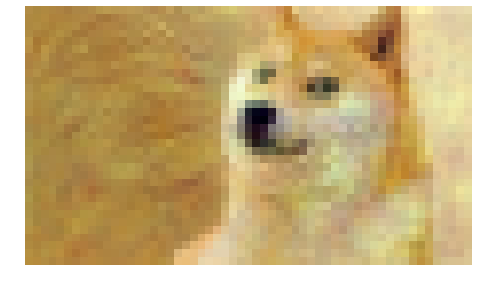

done.
octave 1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

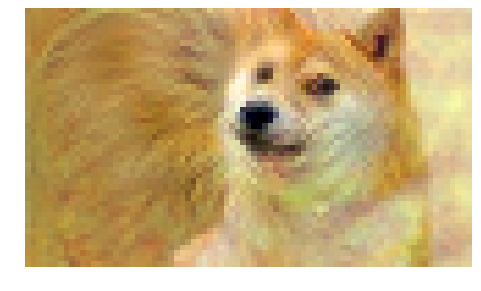

done.
octave 2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

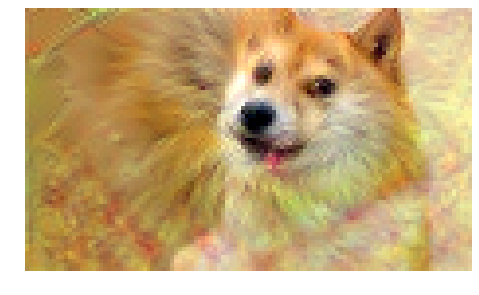

done.
octave 3
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

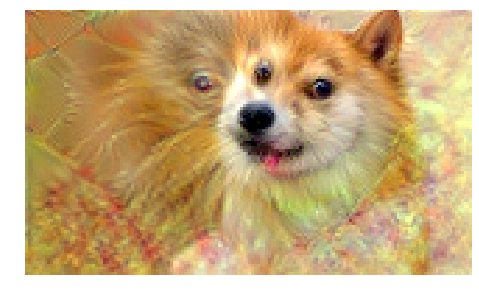

done.
octave 4
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

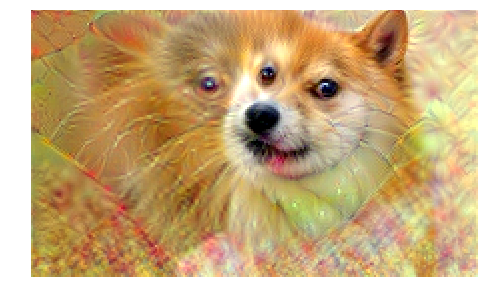

done.


In [0]:
target = graph.get_tensor_by_name("resnet_model/{}:0".format('block_layer3'))
out = deepdream(graph, input_tensor, sess, target, img, 
                n_iter=30, rate=2.0, n_octave=5+0, octave_scale=1.4, image_scale_mul=1)
showarray(out, show=False)

In [0]:
sess.close()